In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


In [ ]:
def dataPipeline(df):



    df_live, df_backup = train_test_split(df,test_size=0.3, random_state=42)

    num_cols = df_live.select_dtypes([np.number]).columns
    df_nums = df_live[num_cols].reset_index(drop=True)
    df_nums = df_nums.dropna()
    X = df_nums.loc[:,df_nums.columns != 'price']
    y = df_nums['price'].values

    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

    selected_columns_2 = ['squareMeters', 'longitude']
    selected_columns_3 = ['squareMeters', 'longitude', 'poiCount']
    selected_columns_5 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance']
    selected_columns_7 = ['squareMeters', 'longitude', 'poiCount', 'rooms', 'centreDistance', 'clinicDistance', 'kindergartenDistance']

    X2=X_normalized_df[selected_columns_2]
    X3=X_normalized_df[selected_columns_3]
    X5=X_normalized_df[selected_columns_5]
    X7=X_normalized_df[selected_columns_7]

    FeatureDividedData = {'X2':X2,'X3':X3,'X5':X5,'X7':X7}

    workableData = {'X':X,'y':y,'X_normalized':X_normalized,'X_normalized_df':X_normalized_df,'FeatureDividedData':FeatureDividedData}

    dataJourney={'df_live':df_live,'df_backup':df_backup,'df_nums':df_nums,'scaler':scaler,'workableData':workableData}

    return dataJourney

In [ ]:
def getData():
    df_august = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_08.csv')
    df_september = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_09.csv')
    df_october = pd.read_csv('https://raw.githubusercontent.com/WitoldSurdej/PFML/master/apartments_pl_2023_10.csv')

    df_august['Month'] = 0
    df_september['Month'] = 1
    df_october['Month'] = 2

    frames = [df_august, df_september, df_october]
    df = pd.concat(frames)

    dataJourney = dataPipeline(df)

    return dataJourney

In [ ]:
class Model:
    def __init__(self):
        self.model = tf.keras.Sequential()
        self.history={}
        self.RMSE={}
        self.config=[]
        self.activationFinction = 'sigmoid'
        self.configs=[[2,1],[2,2,1]]
        self.num_iterations=10
        self.learning_rate = 0.1
        self.total_epochs = 50



    def get_RMSE(self,X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test):
        y_predict_train = self.model.predict(X1_train1)
        y_predict_val = self.model.predict(X1_validation)
        y_predict_test = self.model.predict(X_test)

        rmse_train=np.sqrt(mean_squared_error(y1_train1, y_predict_train))
        rmse_val=np.sqrt(mean_squared_error(y1_validation, y_predict_val))
        rmse_test=np.sqrt(mean_squared_error(y_test, y_predict_test))

        self.RMSE={'train':rmse_train,'validation':rmse_val,'test':rmse_test}

    def config_setup(self,num_of_features):


        #clearing the model to initiate new config
        del self.model
        self.model = tf.keras.Sequential()

        self.model.add(Input(shape=(num_of_features,)))
        activationfunction = self.activationFinction
     #   self.model.add(Input(shape=(self.config[0],)))
     #   self.model.add(Dense(self.config[1],activation='relu',input_shape=(self.config[0],)))
        for layer in range(len(self.config)):
            self.model.add(Dense(self.config[layer], activation=activationfunction))
        self.model.add(Dense(1))
        # Compile the model
        learning_rate = self.learning_rate
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse'])

        patience = int(np.round( self.total_epochs * 0.1))

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',  # Monitor validation loss
          patience=patience,  # Stop training if no improvement for 5 consecutive epochs
          restore_best_weights=True  # Restore model weights to the best observed during training
          )
        return early_stopping_callback

    def train_Model(self,X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test):

        num_of_features = len(X1_train1.columns)

        early_stopping_callback = self.config_setup(num_of_features)
        history = self.model.fit(X1_train1, y1_train1, epochs=self.total_epochs, validation_data=(X1_validation, y1_validation), callbacks=[early_stopping_callback])
        self.history = {'loss': history.history['loss'],'val_loss':history.history['val_loss']}

        self.get_RMSE(X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test)

    def save_Model(self,name):
        self.model.save(name)
        #here insert code for saving history in a separate file. model.history is lost after saving model

    #def load_history(self):

    def load_Model(self,name):
        self.model=tf.keras.models.load_model(name)

    def Model_Across_Iterations(self,X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test):
        num_iterations = self.num_iterations
        modelList=[]
        loss = []
        val_loss = []
        RMSE = []
        for iteration in range(num_iterations):
            self.train_Model(X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test)
            loss.append(self.history['loss'])
            val_loss.append(self.history['val_loss'])
            #self.save_Model(f'model_{iteration}.h5')
            modelList.append(self)
            RMSE.append(self.RMSE)
        return modelList, loss, val_loss, RMSE

    def Model_Across_Permutations(self,X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test):
        modelList = []
        loss = []
        val_loss = []
        RMSE = []
        configs = self.configs

        for config in configs:
            self.config = config
            modelList_per_iteration, loss_per_iteration, val_loss_per_iteration, RMSE_per_iteration = self.Model_Across_Iterations(X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test)
            modelList.append(modelList_per_iteration)
            loss.append(loss_per_iteration)
            val_loss.append(val_loss_per_iteration)
            RMSE.append(RMSE_per_iteration)
        return modelList, loss, val_loss, RMSE

    def Model_Across_DataSets(self,datasets):
      dataFrame = getData()

      modelList = []
      loss = []
      val_loss = []
      RMSE = []

      for i in datasets:
          X2=dataFrame['workableData']['FeatureDividedData'][f'X{i}']
          y=dataFrame['workableData']['y']

          X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=42)
          X1_train1, X1_validation, y1_train1, y1_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state=42)



          modelList_per_permutation, loss_per_permutation, val_loss_per_permutation, RMSE_per_permutation = self.Model_Across_Permutations(X1_train1, y1_train1,X1_validation, y1_validation,X_test,y_test)

          modelList.append(modelList_per_permutation)
          loss.append(loss_per_permutation)
          val_loss.append(val_loss_per_permutation)
          RMSE.append(RMSE_per_permutation)
      return modelList, loss, val_loss, RMSE




In [ ]:
def config_randomSearch(n_of_configs):


    configs=[]

    for i in range(n_of_configs):
        num_of_layers = np.random.randint(5, 100)
        level = np.random.randint(0, 500)
        num_of_layers = np.random.randint(5, 10)
        config = np.random.randint(5, 100,size=(num_of_layers))+level
        configs.append(list(config))
    return configs

In [ ]:
def plot_Configs(configs):
    fig, axs = plt.subplots(len(configs), figsize=(10, 2 * len(configs)),sharey=True,sharex=True)

    for i, config in enumerate(configs):
        axs[i].bar(np.arange(len(config)), config)
        axs[i].set_title(f'Configuration {i+1}')
        axs[i].set_xlabel('Layers')
        axs[i].set_ylabel('Number in Layer')
        axs[i].set_xticks(np.arange(len(config)))
        axs[i].set_xticklabels([f'Layer {j+1}' for j in range(len(config))])

    plt.tight_layout()
    plt.show()

In [ ]:
def lossPlot(datasets,modelList,loss,val_loss):
    for i, dataset in enumerate(datasets):
        fig, axs = plt.subplots(1, len(modelList[0]), figsize=(30,5), sharey=True)
        for j, models in enumerate(modelList[i]):
            for k, model in enumerate(models):
                axs[j].plot(loss[i][j][k],'b')  # Plot loss for each permutation
                axs[j].plot(val_loss[i][j][k],'r')  # Plot val_loss for each permutation
            axs[j].set_title(f'Dataset {dataset}, Model {j+1}')
            axs[j].legend()
            plt.xlabel('epoch')
            plt.ylabel('loss')
        plt.tight_layout()
        plt.show()

In [ ]:
def boxPlot(datasets,modelList,RMSE):
    # Plotting RMSE as Box Plots
    fig, axs = plt.subplots(len(datasets), 1, figsize=(10, 10),sharey=False)
    RMSE_RAW=[]
    RMSE_mean=[]
    for i, dataset in enumerate(datasets):
        data_for_boxplot = []  # Prepare data for boxplot
        RMSE_mean_dataset = []
        for j, models in enumerate(modelList[i]):
            RMSE_in_permutation = []
            for k, model in enumerate(models):
                RMSE_in_iteration=RMSE[i][j][k]['test']  # Append RMSE for each permutation and dataset
                RMSE_in_permutation.append(RMSE_in_iteration)
            RMSE_in_permutation_mean=np.mean(RMSE_in_permutation)
            data_for_boxplot.append(RMSE_in_permutation)
            RMSE_mean_dataset.append(RMSE_in_permutation_mean)
        axs[i].boxplot(data_for_boxplot)
        axs[i].set_title(f'RMSE for Dataset {dataset}')
        RMSE_RAW.append(data_for_boxplot)
        RMSE_mean.append(RMSE_mean_dataset)
    plt.tight_layout()
    plt.show()
    return RMSE_RAW,RMSE_mean

In [ ]:
def expDecay_of_learningRate(initial_learning_rate,final_learning_rate,total_epochs):
    # Define the initial and final learning rates
    #initial_learning_rate = 1.0
    #final_learning_rate = 0.001
    #total_epochs = 100
    # Calculate the decay factor
    decay_factor = final_learning_rate / initial_learning_rate
    # Calculate the decay rate per epoch
    decay_rate = decay_factor ** (1 / total_epochs)
    # Create a learning rate schedule with exponential decay
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_rate=decay_rate,
        decay_steps=1,
        staircase=True  # For discrete steps (staircase decay)
    )


    # Create an array of epochs
    epochs = np.arange(1, total_epochs + 1)

#    Calculate learning rates for each epoch using the exponential decay formula
    lr_values = initial_learning_rate * (decay_rate ** epochs)

    # Plotting the learning rate schedule
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, lr_values, label='Learning Rate', marker='o')
    plt.title('Exponential Decay Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


    return lr_schedule


In [ ]:
total_epochs = 400
model=Model()
model.total_epochs = total_epochs
model.num_iterations = 2
model.learning_rate = 0.1
configs=[[2],[4],[2,2]]
model.configs = configs


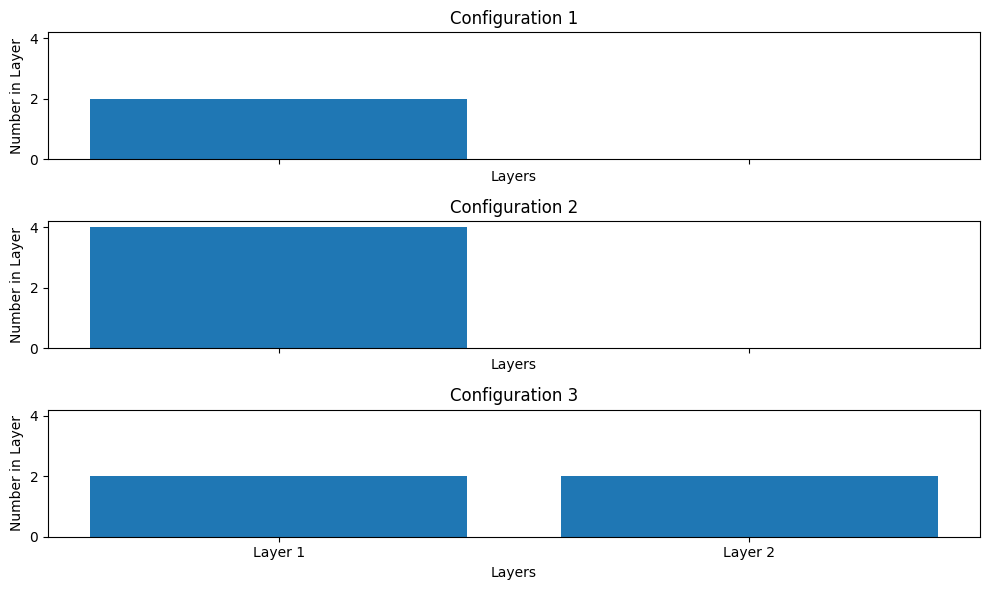

In [ ]:
plot_Configs(configs)

In [ ]:
datasets = [2,3,5,7]
modelList, loss, val_loss, RMSE = model.Model_Across_DataSets(datasets)

Streaming output truncated to the last 5000 lines.
Epoch 312/400
423/423 [==============================] - 2s 5ms/step - loss: 615912374272.0000 - mse: 615912374272.0000 - val_loss: 655108276224.0000 - val_mse: 655108276224.0000
Epoch 313/400
423/423 [==============================] - 2s 4ms/step - loss: 615735099392.0000 - mse: 615735099392.0000 - val_loss: 654927134720.0000 - val_mse: 654927134720.0000
Epoch 314/400
423/423 [==============================] - 2s 5ms/step - loss: 615558479872.0000 - mse: 615558479872.0000 - val_loss: 654746058752.0000 - val_mse: 654746058752.0000
Epoch 315/400
423/423 [==============================] - 2s 5ms/step - loss: 615380746240.0000 - mse: 615380746240.0000 - val_loss: 654565113856.0000 - val_mse: 654565113856.0000
Epoch 316/400
423/423 [==============================] - 2s 5ms/step - loss: 615204061184.0000 - mse: 615204061184.0000 - val_loss: 654383710208.0000 - val_mse: 654383710208.0000
Epoch 317/400
423/423 [==============================]

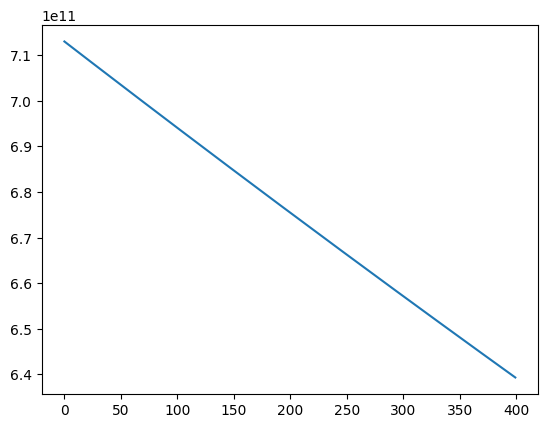

In [ ]:
plt.plot(val_loss[0][0][0])
plt.show()

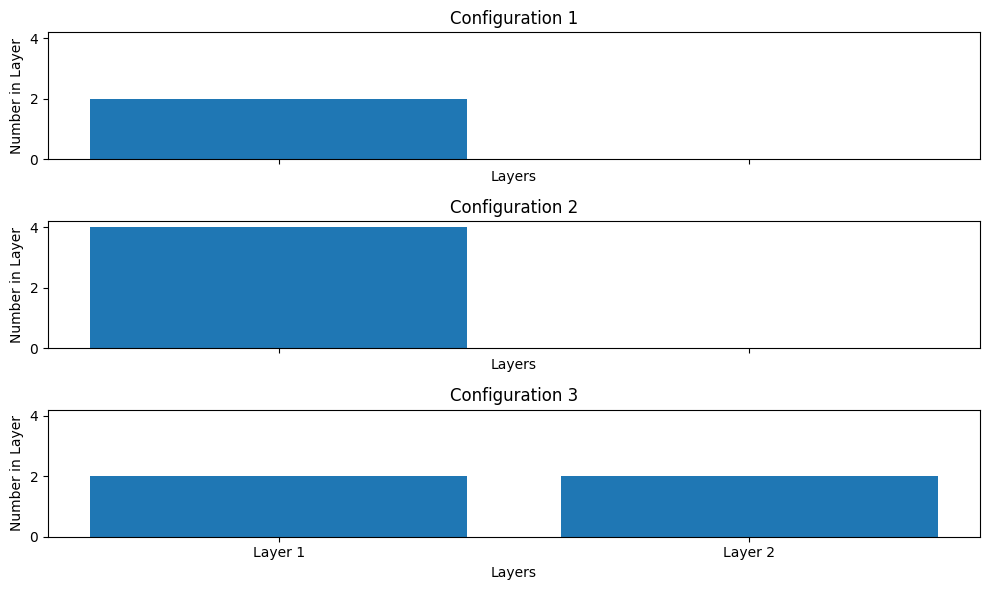

In [ ]:
plot_Configs(configs)

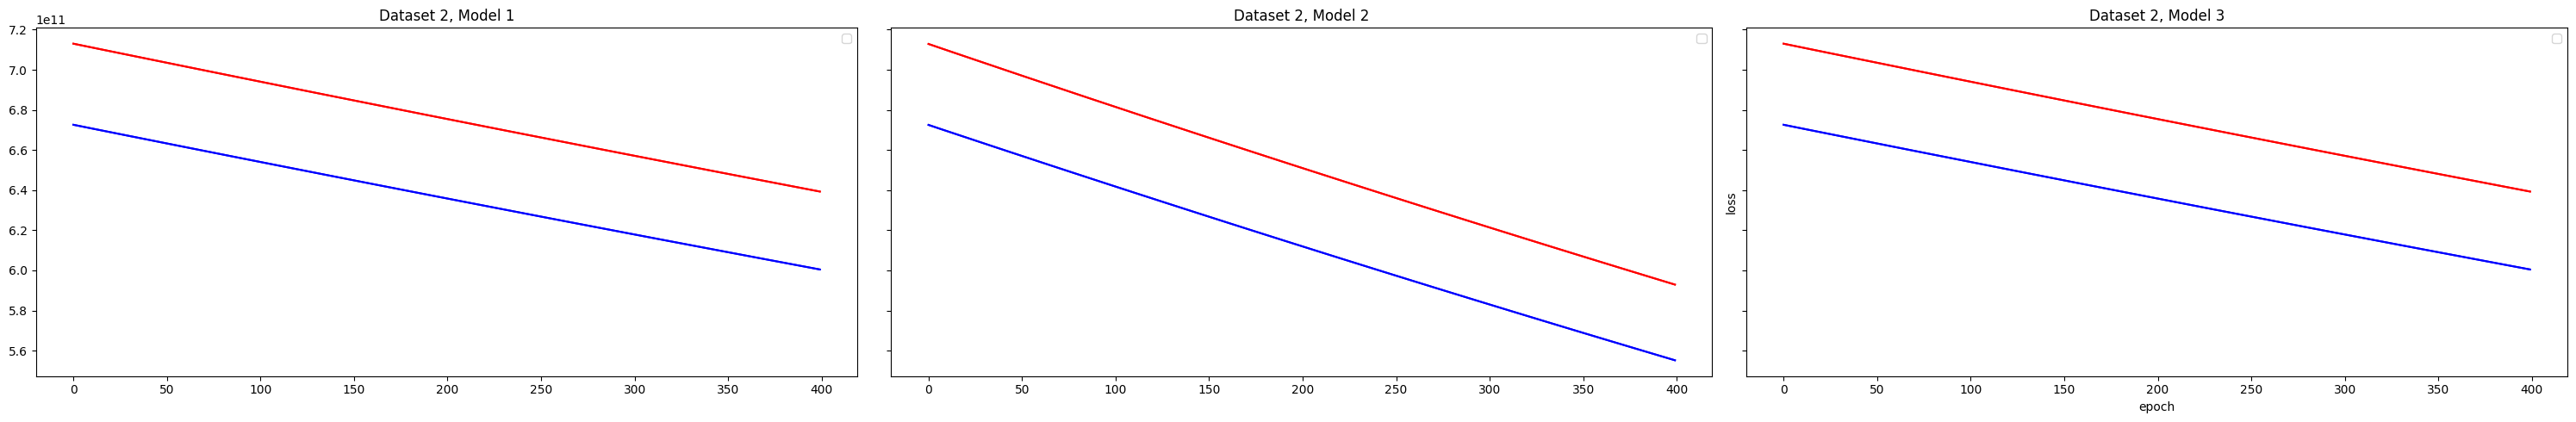

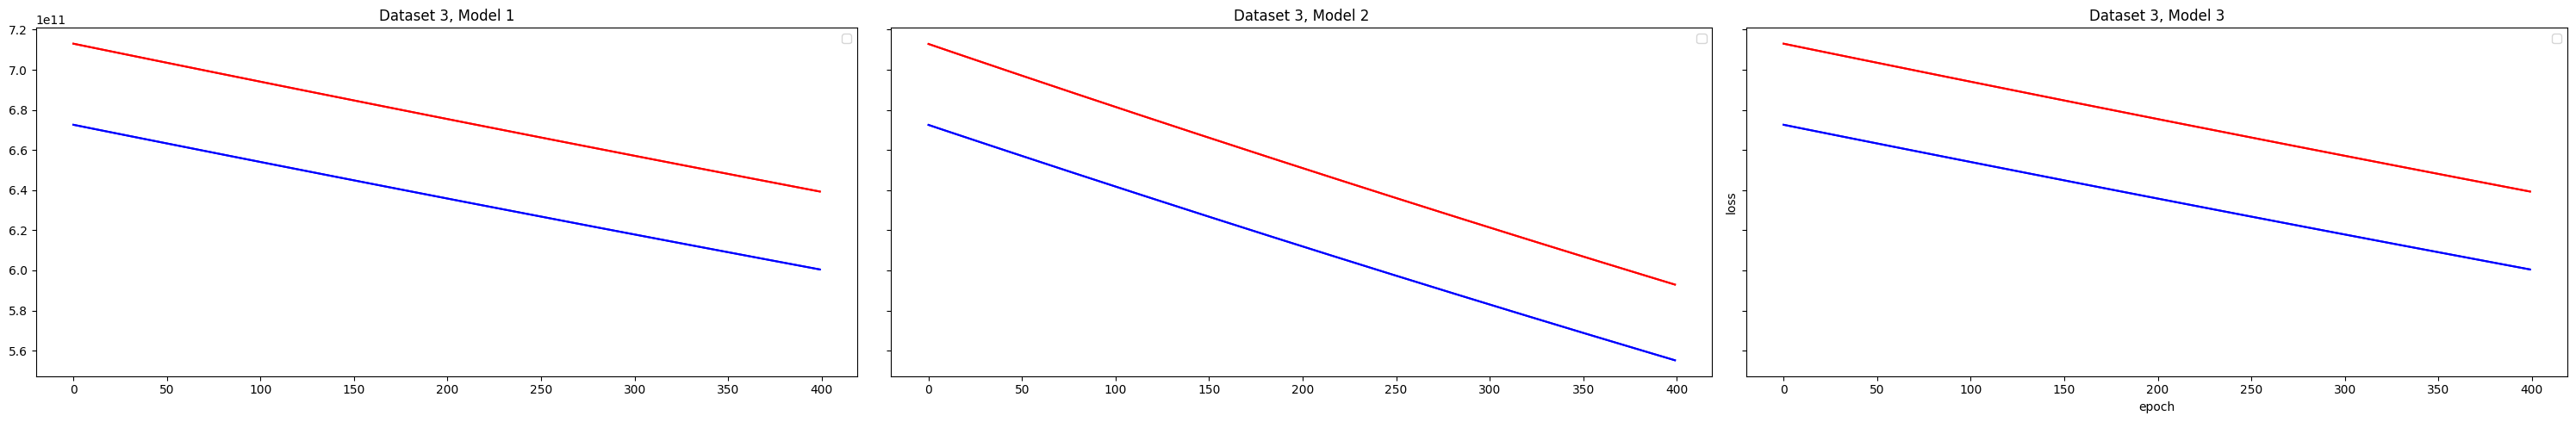

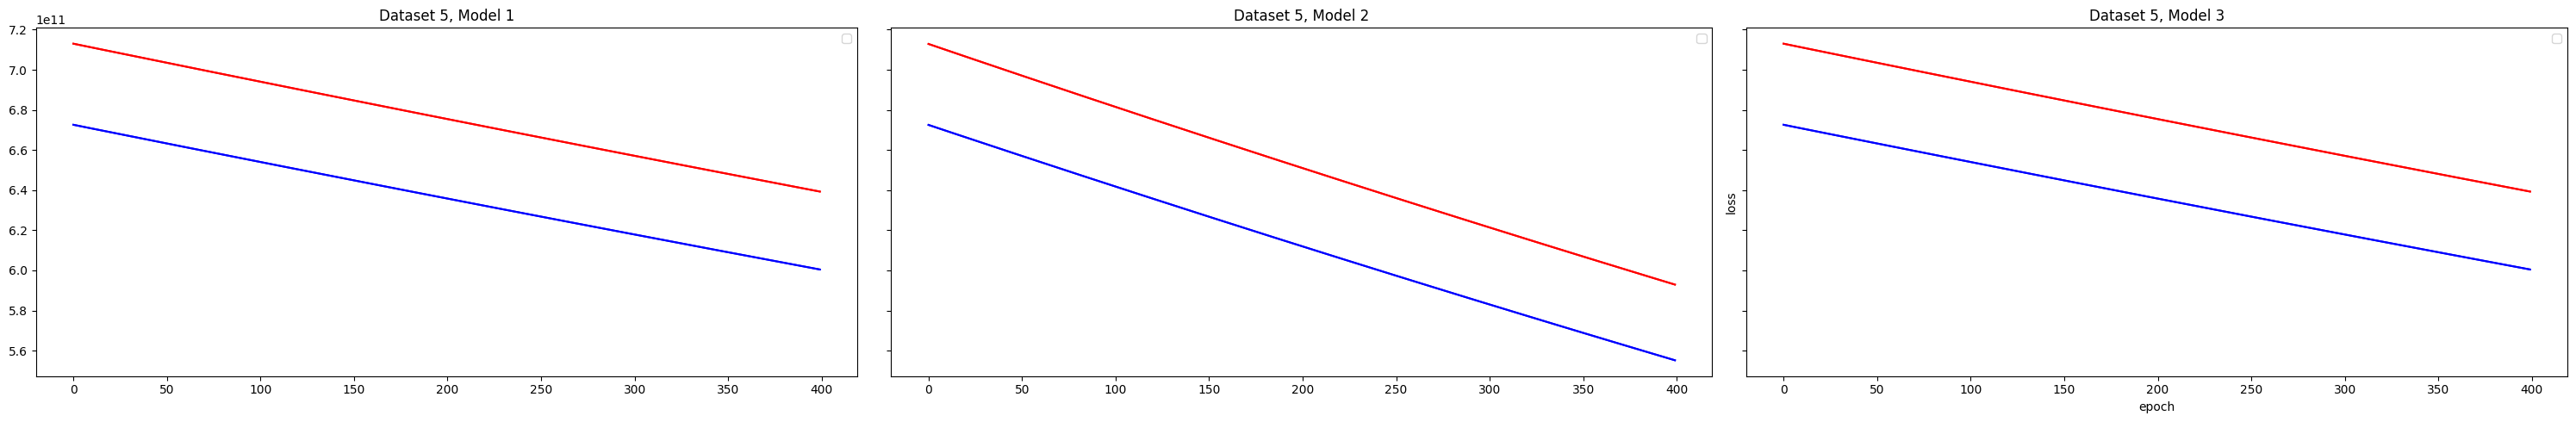

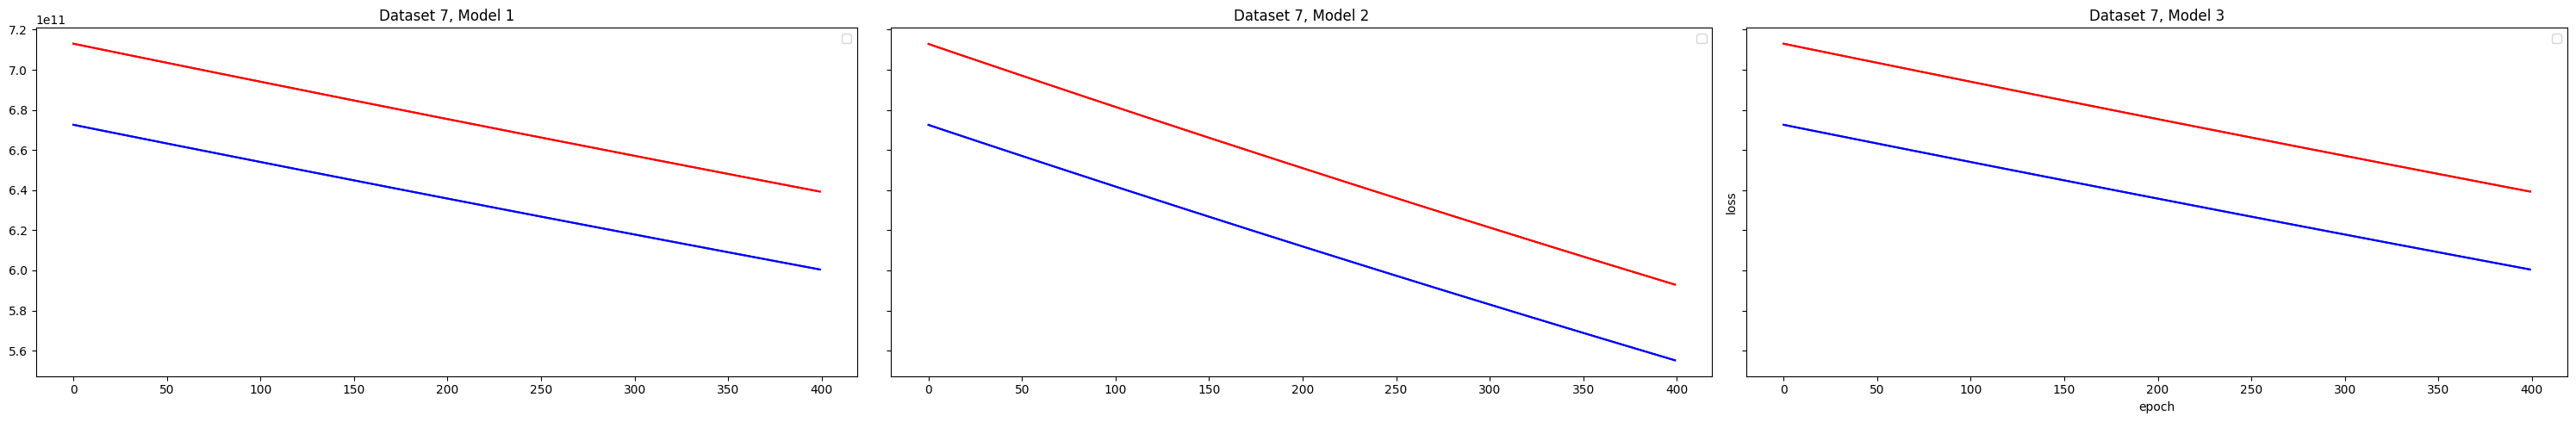

In [ ]:
lossPlot(datasets,modelList,loss,val_loss)

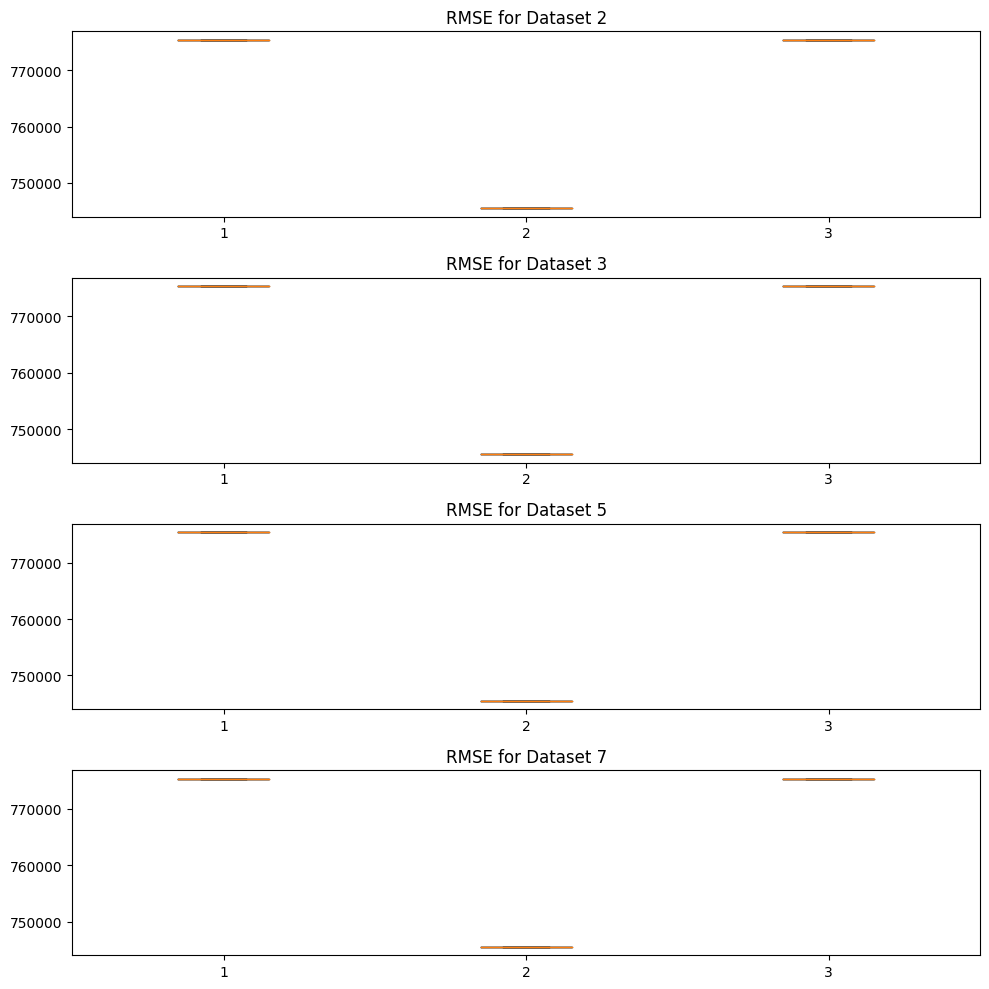

In [ ]:
RMSE_RAW,RMSE_mean = boxPlot(datasets,modelList,RMSE)

In [ ]:

# Convert RMSE_RAW to a NumPy array for easier manipulation
RMSE_mean_np = np.array(RMSE_mean)

# Calculate the mean along the iteration axis (axis=1)
mean_rmse_per_dataset = np.mean(RMSE_mean_np, axis=1)

# Find the index of the dataset with the smallest mean RMSE
min_mean_index = np.unravel_index(np.argmin(mean_rmse_per_dataset), mean_rmse_per_dataset.shape)

print(min_mean_index)  # Output the index of the dataset with the smallest mean RMSE

(3,)


In [ ]:
# Convert RMSE_RAW to a NumPy array for easier manipulation
RMSE_RAW_np = np.array(RMSE_RAW)

# Calculate the mean along the iteration axis (axis=1)
mean_rmse_per_dataset2 = np.mean(RMSE_RAW_np, axis=1)

# Find the index of the dataset with the smallest mean RMSE
min_mean_index2 = np.unravel_index(np.argmin(mean_rmse_per_dataset2), mean_rmse_per_dataset2.shape)

print(min_mean_index2)  # Output the index of the dataset with the smallest mean RMSE




(2, 1)


In [ ]:
print(RMSE_mean[1]) #figure out mean finding
print(RMSE_RAW[0][2])

[775385.580579733, 745528.9168654436, 775385.6467438656]
[775384.5794096708, 775382.9009281348]
